# Deep Neural Networks (DNNs)

### Objectives:
- Recall some important concepts about DNNs 
- Using DNNs to solve a real-life classification problem in the banking industry
- Use of PyTorch's custom modules to define the network architecture and train the model
- Exploration of error analysis to improve the model performance


### Recall of Important Concepts

Artificial neural nets consists of dense layers and activations.

1. What's the difference between deep learning and normal machine learning?

    1. <span style="color:lightblue">After a certain point, adding more data for traditional ML algorithms won't improve the performance and the learning curve will saturate (plateau), but for DL, you can generally get better performance by providing more training data.</span>
    2. <span style="color:lightblue">There's generally no handcrafted feature extraction step in DNNs.</span>
    3. <span style="color:lightblue">DNNs need high computational power for training.</span>

2. How does a neural network with no hidden layers and one output neuron compare to a logistic/linear regression?
    <span style="color:lightblue"> There's no difference. NN with no hidden layers is perceptron which has the same architecture of logistic/linear regression. If the activation function in the output layer is linear and loss is mse then it is linear regression. If the activation function in the output layer is sigmoid and the loss is the logloss then it is logistic regression.</span>

3. In multi-hidden layers network, what's the need of non-linear activation function?
    <span style="color:lightblue"> To capture the non linear patterns in the relation between the input and the output, and represent it as non-linear features.</span>

4. Is random weight assignment better than assigning same weights to the units in the hidden layer?
    <span style="color:lightblue"> Yes, because random initialization helps to break symmetry in the network and promote diversity in the learning of each neuron, leading to better optimization and reducing the risk of getting stuck in suboptimal solutions. Using the same weight values across all neurons can result in the network making the same mistakes, leading to poor performance.</span>

---

## Solving a Classification problem using DNNs

In the following sections, we will solve a classification task related to credit card payments using the Default of Credit Card Clients dataset. We will use this data to build a model that is able to determine whether a new client will default on the upcoming payment or not, thus we are solving a binary classification problem.

## Loading and Preparing the Dataset

Loading the data and printing the head of the dataset. It will be a good idea to read the documentation of read_excel function at https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html

In [3]:
import pandas as pd
from torch.nn import NLLLoss

data = pd.read_excel("data/default of credit card clients.xls", skiprows=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


The shape of the dataset is 30,000 rows and 25 columns, which can be obtained using the following line of code:

In [4]:
print("rows:",data.shape[0]," columns:", data.shape[1])

rows: 30000  columns: 25


As we learned earlier in the semester, sometimes our data might contain irrelevant features which can be removed before model training. For example, in our classification problem the features ID and Sex can be considered as irrelevant and we can remove them as follows

In [5]:
data_clean = data.drop(columns=["ID", "SEX"])
data_clean.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,1,24,2,2,-1,-1,-2,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,26,-1,2,0,0,0,2,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,34,0,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,1,37,0,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,2,1,57,-1,0,-1,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Let's check if our data has any missing values.

In [6]:
total = data_clean.isnull().sum()
percent = (data_clean.isnull().sum()/data_clean.isnull().count()*100)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since our data does not have any missing values, no further action is required.
<br>
However, if it had, we can handle them in several ways:

- Drop missing values: Remove all rows or columns containing missing values.
- Impute missing values: Fill in missing values with mean, median, mode, or other values.
    - SimpleImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
    - KNNImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)
- Predict missing values: Use a machine learning model to predict missing values.
    - IterativeImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)
- Using flags to indicate missing values: Add an extra column indicating the presence of missing values.
- Interpolation: Interpolating missing values based on other values.
    - scipy.interpolate.interp1d (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)
- Using external sources of data to fill missing values.

It is a good idea to check for class imbalance as well, which can be detected by simply counting the occurrences of each of the classes in the target feature, as shown here:

In [7]:
target = data_clean["default payment next month"]
yes_count = target[target == 1].count()
no_count = target[target == 0].count()
print("yes %: " + str(yes_count / len(target) * 100) + " - no %: " \
      + str(no_count / len(target) * 100))

yes %: 22.12 - no %: 77.88000000000001


These results can also be displayed in a plot using the following lines of code:

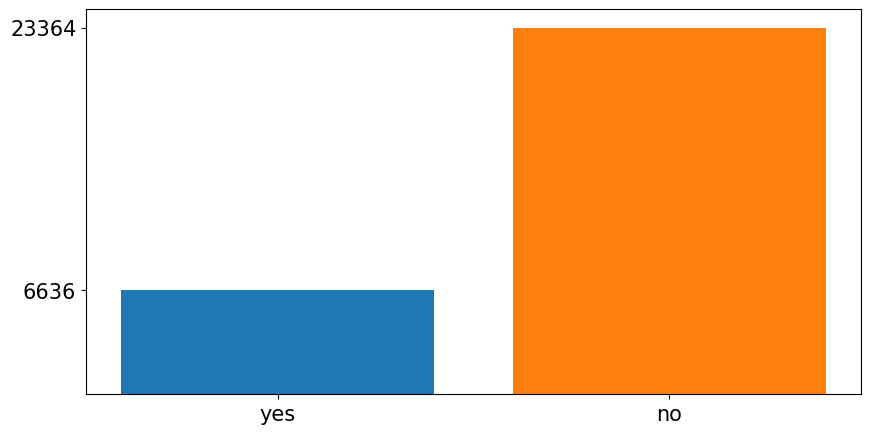

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.bar("yes", yes_count)
plt.bar("no", no_count)
ax.set_yticks([yes_count, no_count])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

To resolve the issue, since no additional data can be added and accuracy is the performance metric, data resampling is required. The code below implements oversampling on the dataset, randomly duplicating rows of the class with fewer representation.

<br>

Two functions to look into are:

- sample https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

- concat https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [9]:
data_yes = data_clean[data_clean["default payment next month"] == 1]
data_no = data_clean[data_clean["default payment next month"] == 0]
# generate additional datapoints with the 'yes' output class
# no_count is used as the target count for the 'yes' class records
over_sampling = data_yes.sample(n=no_count, replace=True, random_state=0)
# create a new dataset that includes the 'no' class datapoints and the "extended" 'yes' class datapoints
# NOTE: this will result in a dataset with a modified, non-contiguous index column. We'll reset the index later.
data_resampled = pd.concat([data_no, over_sampling], axis=0)
data_resampled

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
2,90000,2,2,34,0,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,1,37,0,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,2,1,57,-1,0,-1,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,2,37,0,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,2,29,0,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,40000,1,2,23,2,2,2,0,0,0,...,21420,23066,23683,1500,1000,1000,2000,1000,894,1
8362,50000,3,1,52,0,0,2,-1,0,0,...,14580,11231,10804,1656,0,14580,500,458,873,1
6687,260000,2,1,42,3,3,2,2,0,0,...,208821,213083,217340,0,8000,0,7800,7800,8300,1
16434,30000,2,1,53,0,0,0,0,0,2,...,17717,19420,18970,1500,1500,1600,2000,0,1500,1


Let's split the dataset into a features matrix and a target matrix.

In [10]:
data_resampled = data_resampled.reset_index(drop=True)
# X = data_resampled.drop(columns=["default payment next month"])
# reduce the feature set to just those with an association score of 0.1 or more with the target
keep_columns = ["LIMIT_BAL", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "PAY_AMT1"]
drop_columns = list(set(data_resampled.columns) - set(keep_columns))
print(f"{drop_columns=}")
print(f"{keep_columns=}")

X = data_resampled.drop(columns=drop_columns)
y = data_resampled ["default payment next month"]
# This copy of the dataframe will have a contiguous index starting at zero
# X



drop_columns=['BILL_AMT3', 'PAY_AMT4', 'BILL_AMT6', 'default payment next month', 'BILL_AMT5', 'PAY_AMT3', 'EDUCATION', 'BILL_AMT4', 'PAY_AMT2', 'AGE', 'BILL_AMT2', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'MARRIAGE']
keep_columns=['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1']


Rescale the values of the features matrix in order to avoid introducing bias to the model:

In [11]:
X = (X - X.min())/(X.max() - X.min())
X.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1
0,0.080808,0.2,0.2,0.2,0.2,0.2,0.2,0.001738
1,0.040404,0.2,0.2,0.2,0.2,0.2,0.2,0.002290
2,0.040404,0.1,0.2,0.1,0.2,0.2,0.2,0.002290
3,0.040404,0.2,0.2,0.2,0.2,0.2,0.2,0.002862
4,0.494949,0.2,0.2,0.2,0.2,0.2,0.2,0.062961


To ease the use of the prepared dataset for future tasks, we combine the feature (X) and target (y) matrices into a single Pandas DataFrame and save as a CSV file using the code provided below.


In [12]:
final_data = pd.concat([X, y], axis=1)
final_data.to_csv("data/dccc_prepared.csv", index=False)

## Model Training

We start by importing all important libraries. The most important one in today's activity is Pytorch. Please read more about Pytorch at https://pytorch.org/docs/stable/index.html

In [13]:
# use the scikit-learn array API for better performance (use the GPU)
# run this on the command line before importing scipy and scikit-learn
# export SCIPY_ARRAY_API=1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import sklearn
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

sklearn.set_config(array_api_dispatch=True)

Loading the dataset we prepared for modeling in the previous step. 

In [14]:
data = pd.read_csv("data/dccc_prepared.csv")
data.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,default payment next month
0,0.080808,0.2,0.2,0.2,0.2,0.2,0.2,0.001738,0
1,0.040404,0.2,0.2,0.2,0.2,0.2,0.2,0.002290,0
2,0.040404,0.1,0.2,0.1,0.2,0.2,0.2,0.002290,0
3,0.040404,0.2,0.2,0.2,0.2,0.2,0.2,0.002862,0
4,0.494949,0.2,0.2,0.2,0.2,0.2,0.2,0.062961,0


Separate the inputs and targets

In [15]:
# X <-- all rows, all columns but the last
X = data.iloc[:,:-1]
# y <-- the last column, by name
y = data["default payment next month"]

Split the data into three parts:
- training data
- validation data
- test data

In [16]:
# import sklearn
sklearn.set_config(array_api_dispatch=True)

# convert the feature and target dataframes to arrays so sklearn can handle them
# (with the sklearn array api turned on, train_test_split expects an array)
X_arr = X.values
y_arr = y.values

# split the test data (20%) from a "new" data range
# X_new, X_test, y_new, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_new, X_test, y_new, y_test = train_test_split(X_arr, y_arr, test_size=0.2, random_state=0)
# define the exact ratio of test data to the "new" data range
dev_per = X_test.shape[0]/X_new.shape[0]
print(f"{dev_per=}")
# split the "new" data range into training data and validation (dev) data
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)
# convert the split datasets back to dataframes
X_train = pd.DataFrame(X_train)
X_dev = pd.DataFrame(X_dev)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train.flatten())
y_dev = pd.DataFrame(y_dev.flatten())
y_test = pd.DataFrame(y_test.flatten())

y_train

dev_per=0.2500133754213258


,0
0,0
1,0
2,1
3,1
4,0
...,...
28031,1
28032,1
28033,1
28034,0


In [17]:
print("Training sets:",X_train.shape, y_train.shape)
print("Validation sets:",X_dev.shape, y_dev.shape)
print("Testing sets:",X_test.shape, y_test.shape)

Training sets: (28036, 8) (28036, 1)
Validation sets: (9346, 8) (9346, 1)
Testing sets: (9346, 8) (9346, 1)


Convert the validation and testing sets into tensors, considering that the features' matrix should be of the float type, while the target matrix should not. Leave the training sets unconverted for the moment as they will undergo further transformations.

There are optimizations available for Apple Silicon chips from pytorch out of the box.
We'll use the Metal Performance Shaders (MPS) accelerator when working with pytorch tensors in order to maximize performance on this particular machine.

In [18]:
# confirm that an accelerator device is available
print(f"mps.device_count: {torch.mps.device_count()}")
# use the MPS Pytorch accelerator (see https://docs.pytorch.org/docs/stable/mps.html#module-torch.mps)
mps_device = torch.device("mps:0" if torch.mps.is_available() else "cpu")

# X_dev_torch = torch.tensor(X_dev.values).float()
X_dev_torch = torch.tensor(data=X_dev.values).to(dtype=torch.float32).to(device=mps_device)
# X_dev_torch = torch.tensor(data=X_dev).to(dtype=torch.float32).to(device=mps_device)
# y_dev_torch = torch.tensor(y_dev.values)
y_dev_torch = torch.tensor(y_dev.values).to(dtype=torch.float32).to(device=mps_device)
y_dev_torch_flat = y_dev_torch.flatten()
# y_dev_torch = torch.tensor(y_dev).to(dtype=torch.float32).to(device=mps_device)
# X_test_torch = torch.tensor(X_test.values).float()
X_test_torch = torch.tensor(X_test.values).to(dtype=torch.float32).to(device=mps_device)
# X_test_torch = torch.tensor(X_test).to(dtype=torch.float32).to(device=mps_device)
# y_test_torch = torch.tensor(y_test.values)
y_test_torch = torch.tensor(y_test.values).to(device=mps_device)
# y_test_torch = torch.tensor(y_test).to(device=mps_device)

mps.device_count: 1


In [ ]:
%%sql


### Tensors

It turns out neural network computations are just a bunch of linear algebra operations on tensors, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.
 

<img style="color: white" src="assets/tensor_examples_dark_mode.svg" width="600px">

Just like Numpy arrays, Pytorch tensors can be added, multiplied, subtracted, etc.

Using PyTorch's custom modules, create a class called Classifier and define the model's architecture so that
it has 

- three hidden layers all having ReLU activation function, 
- and a output layer having Log Softmax activation function:

In [59]:
# hidden_layer_size = 30
# hidden_layer_size = 16
# hidden_layer_size = 40
hidden_layer_size = 64

class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # original hidden layers (3)
        # self.hidden_1 = nn.Linear(in_features=input_size, out_features=10, device=mps_device)
        # self.hidden_2 = nn.Linear(in_features=10, out_features=10, device=mps_device)
        # self.hidden_3 = nn.Linear(in_features=10, out_features=10, device=mps_device)
        self.hidden_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size, device=mps_device)
        self.hidden_2 = nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size, device=mps_device)
        self.hidden_3 = nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size, device=mps_device)
        # self.hidden_1 = nn.Linear(in_features=input_size, out_features=20, device=mps_device)
        # self.hidden_2 = nn.Linear(in_features=20, out_features=20, device=mps_device)
        # self.hidden_3 = nn.Linear(in_features=20, out_features=20, device=mps_device)
        # additional hidden layers
        # self.hidden_4 = nn.Linear(in_features=10, out_features=10, device=mps_device)
        # self.hidden_5 = nn.Linear(in_features=10, out_features=10, device=mps_device)
        # self.hidden_6 = nn.Linear(in_features=10, out_features=10, device=mps_device)
        # output layer
        self.output =   nn.Linear(in_features=hidden_layer_size, out_features=2, device=mps_device)
        # self.output =   nn.Linear(in_features=20, out_features=2, device=mps_device)

    def forward(self, x):
        # z = F.relu(self.hidden_1(x))
        # z = F.relu(self.hidden_2(z))
        # z = F.relu(self.hidden_3(z))
        z = F.leaky_relu(self.hidden_1(x))
        z = F.leaky_relu(self.hidden_2(z))
        z = F.leaky_relu(self.hidden_3(z))
        # additional hidden layers
        # z = F.relu(self.hidden_4(z))
        # z = F.relu(self.hidden_5(z))
        # z = F.relu(self.hidden_6(z))
        # output layer
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

Instantiate the model and define all the variables required to train the model. Set the number of epochs to 50 and the batch size to 128. Use a learning rate of 0.001:

In [60]:
learning_rate = 0.001
# learning_rate = 0.002
# learning_rate = 0.0005
# epochs = 50
# epochs = 100
# epochs = 200
epochs = 400
# batch_size = 128
# batch_size = 64
# batch_size = 32
# batch_size = 256
# batch_size = 512
batch_size = 1024

model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Train the network using the training sets. Use the validation sets to measure performance. To do this, save the loss and the accuracy for both the training and validation sets in each epoch:

In [61]:
import sklearn
from torch import Tensor
import torch.nn.modules.loss

# use sklearn array_api_dispatch so that sklearn can handle Tensor objects in place of numpy dtypes
# NOTE: also requires the SCIPY_ARRAY_API=1 environment variable to be set.
#       Since we're running a local Jupyter server, set the env variable there.
sklearn.set_config(array_api_dispatch=True)

train_losses, dev_losses, train_acc, dev_acc= [], [], [], []

for e in range(epochs):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        # X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        X_batch = torch.tensor(X_.iloc[i:b,:].values).to(dtype=torch.float32).to(device=mps_device)
        # y_batch = torch.tensor(y_.iloc[i:b].values)
        # y_batch = torch.tensor(y_.iloc[i:b].values).to(dtype=torch.float32).to(device=mps_device)
        y_batch = torch.tensor(y_.iloc[i:b].values).to(dtype=torch.float32).flatten().to(device=mps_device)
        # y_batch = torch.tensor(y_.iloc[i:b].values).to(dtype=torch.float32).flatten().to(device=mps_device)
        # print(y_batch)

        pred: Tensor = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        # running_acc += accuracy_score(y_batch, top_class)
        # move tensors to CPU before converting to numpy arrays
        # running_acc += accuracy_score(y_batch.cpu(), top_class.cpu())
        # alternative: use a pytorch-native accuracy calculation
        # running_acc += (top_class == y_batch).float().mean().item()
        # alternative 2: use scikit-learn array API so that conversion to numpy isn't necessary
        # https://scikit-learn.org/stable/modules/array_api.html
        running_acc += accuracy_score(y_batch, top_class)

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        pred_dev: Tensor = model(X_dev_torch)
        # TODO: see if this flatten operation can be done earlier
        #  review this for all the splits. Where's the best/earliest place to do it?
        dev_loss = criterion(pred_dev, y_dev_torch_flat)

        ps_dev: Tensor = torch.exp(pred_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)

    train_losses.append(running_loss/iterations)
    dev_losses.append(dev_loss)
    train_acc.append(running_acc/iterations)
    dev_acc.append(acc)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/iterations),
          "Validation Loss: {:.3f}.. ".format(dev_loss),
          "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
          "Validation Accuracy: {:.3f}".format(acc))

# with the MPS accelerator and scikit-learn array_api in place, training takes
# 1m54s
# with these settings:
# epochs: 50
# batch size: 128
# learning rate: 0.001

Epoch: 1/400..  Training Loss: 0.680..  Validation Loss: 0.654..  Training Accuracy: 0.577..  Validation Accuracy: 0.675
Epoch: 2/400..  Training Loss: 0.623..  Validation Loss: 0.602..  Training Accuracy: 0.687..  Validation Accuracy: 0.692
Epoch: 3/400..  Training Loss: 0.595..  Validation Loss: 0.591..  Training Accuracy: 0.695..  Validation Accuracy: 0.692
Epoch: 4/400..  Training Loss: 0.585..  Validation Loss: 0.588..  Training Accuracy: 0.699..  Validation Accuracy: 0.695
Epoch: 5/400..  Training Loss: 0.581..  Validation Loss: 0.584..  Training Accuracy: 0.703..  Validation Accuracy: 0.697
Epoch: 6/400..  Training Loss: 0.580..  Validation Loss: 0.583..  Training Accuracy: 0.702..  Validation Accuracy: 0.698
Epoch: 7/400..  Training Loss: 0.577..  Validation Loss: 0.582..  Training Accuracy: 0.703..  Validation Accuracy: 0.696
Epoch: 8/400..  Training Loss: 0.577..  Validation Loss: 0.581..  Training Accuracy: 0.703..  Validation Accuracy: 0.698
Epoch: 9/400..  Training Loss: 0

Plot both the training and the validation loss

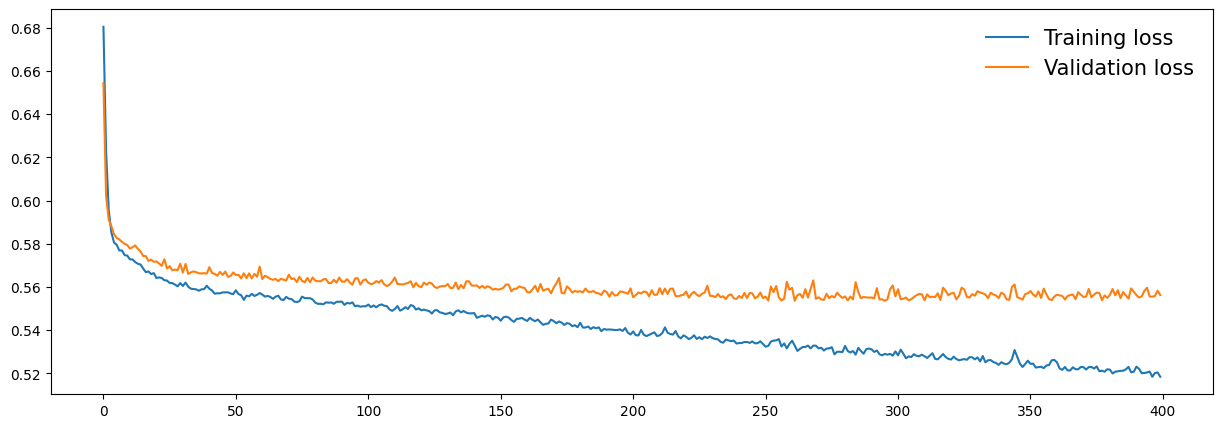

In [62]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Training loss')
# convert dev_losses: list[Tensor] to list[nparray] before plotting
# (pyplot can't handle Tensor objects directly)
# plt.plot(dev_losses, label='Validation loss')
dev_losses_array = [loss_value.cpu().numpy() for loss_value in dev_losses]
plt.plot(dev_losses_array, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

Also plot the training and the validation accuracy

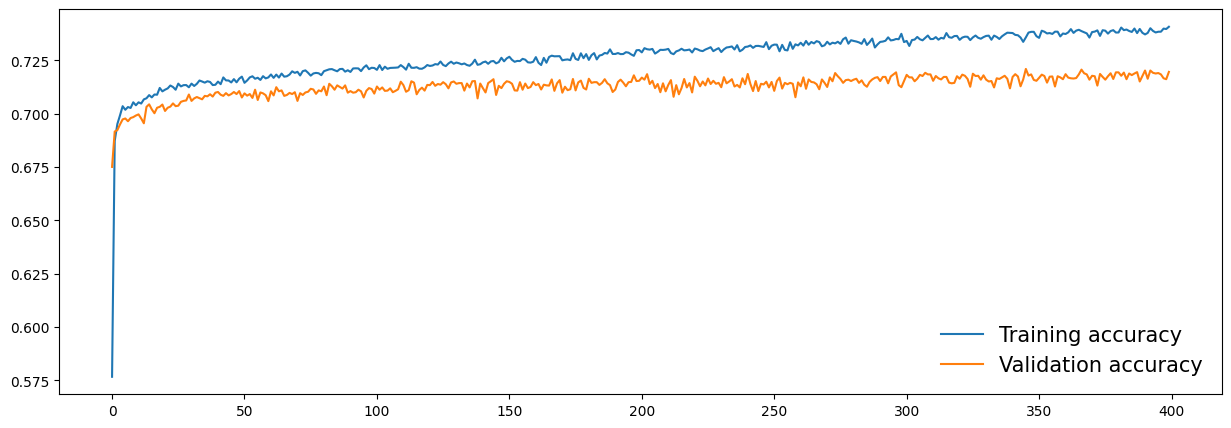

max training accuracy: 0.7406985653298241
max validation accuracy: 0.7209501266479492


In [63]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_acc, label="Training accuracy")
plt.plot(dev_acc, label="Validation accuracy")
plt.legend(frameon=False, fontsize=15)
plt.show()

print(f"max training accuracy: {np.max(train_acc)}")
print(f"max validation accuracy: {np.max(dev_acc)}")

## Challenge Activity

_Based on the error and training curves, what do you think is the model underfitting or overfitting? Provide your answer, justify it, and then take steps to overcome the issue and demonstrate that after making those changes the model works better._

At the end of 50 epochs, the training accuracy was still increasing but beginning to plateau. The accuracy test score is about 71% – not bad but not great.

In a classification model ANN, the number of hidden layers is roughly equivalent to the number of linear boundaries that would be required to separate the data on a plot. For example, consider a dataset with two features and two possible output classes, where class 1 datapoints are clustered at the top left and top right quadrant, and class 2 datapoints are clustered at the bottom centre of a 2D plot. The clusters overlap vertically and horizontally, but do not touch. There is no single straight line we can draw (representing a single perceptron with a linear activation function) that will successfully separate the clusters.

We need at least two lines on the plot to separate the clusters, which corresponds to at least one additional hidden layer.

Looking at our challenge dataset, it has 22 features. Unless a lot of those features are redundant and/or highly correlated with each other (or are linearly dependent), it's unlikely our 3 hidden layers will be enough to provide a complex enough model.

Let's have a quick look at an association matrix of a sample of the data to see if we can gain any insight.


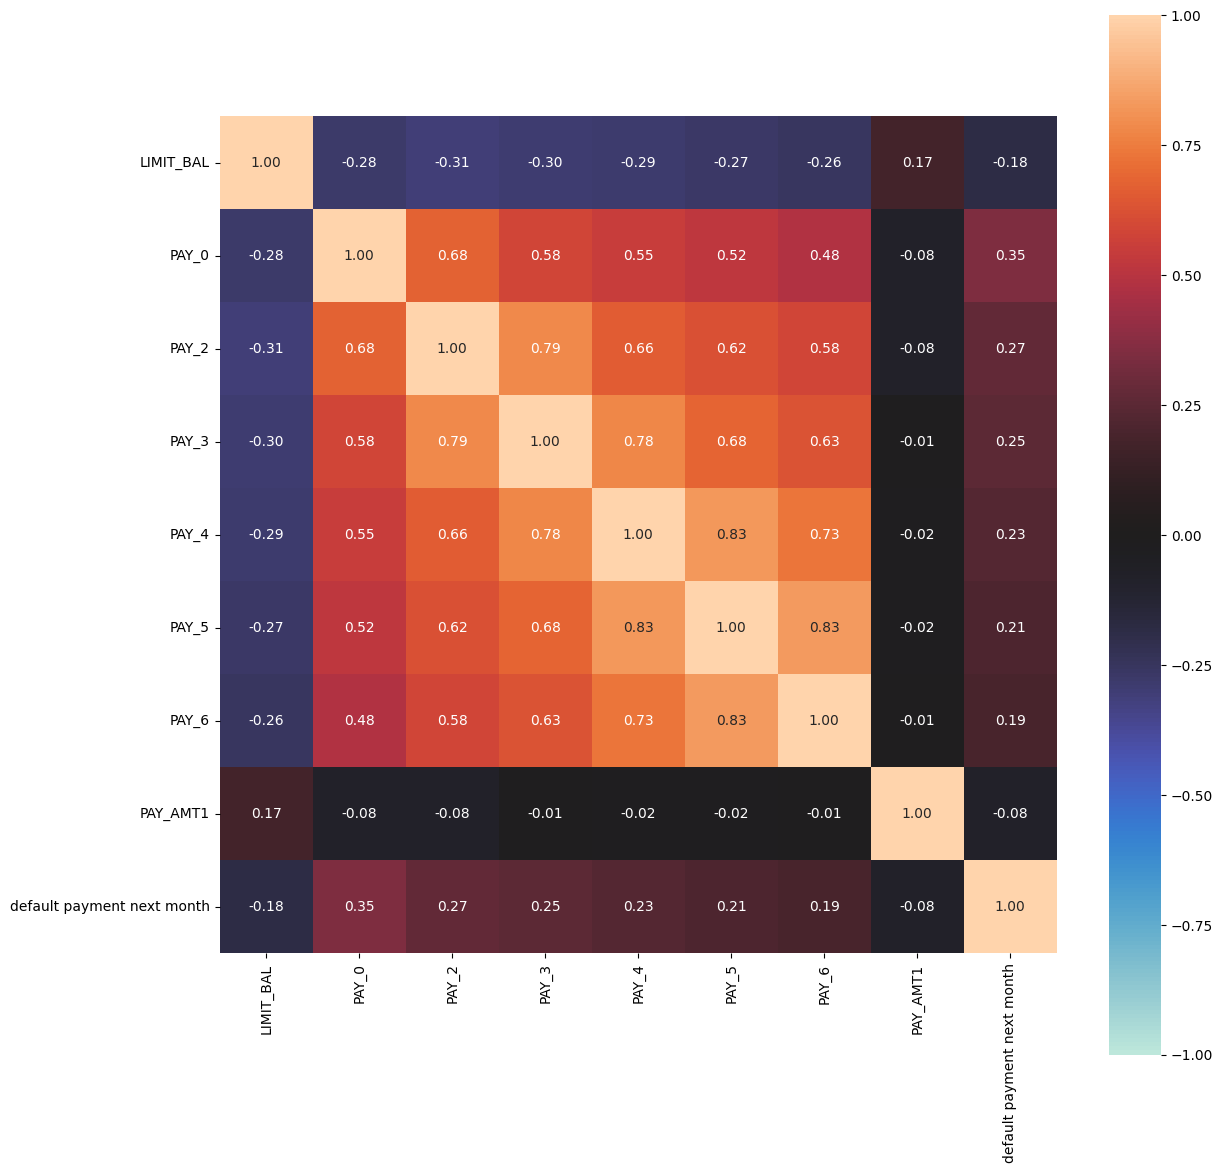

{'corr':                             LIMIT_BAL     PAY_0     PAY_2     PAY_3     PAY_4  \
 LIMIT_BAL                    1.000000 -0.277184 -0.309604 -0.295182 -0.288289   
 PAY_0                       -0.277184  1.000000  0.675847  0.581607  0.547878   
 PAY_2                       -0.309604  0.675847  1.000000  0.786235  0.659119   
 PAY_3                       -0.295182  0.581607  0.786235  1.000000  0.780633   
 PAY_4                       -0.288289  0.547878  0.659119  0.780633  1.000000   
 PAY_5                       -0.267004  0.515968  0.622608  0.682538  0.828024   
 PAY_6                       -0.256953  0.479437  0.578865  0.631785  0.732884   
 PAY_AMT1                     0.171878 -0.079819 -0.081419 -0.010014 -0.020251   
 default payment next month  -0.182262  0.348808  0.270296  0.251647  0.232177   
 
                                PAY_5     PAY_6  PAY_AMT1  \
 LIMIT_BAL                  -0.267004 -0.256953  0.171878   
 PAY_0                       0.515968  0.479437 

In [24]:
# get a sample of the normalized data, including the output values
final_data_sample = final_data.sample(n=10_000)
from dython.nominal import associations
# generate an association matrix (like a correlation matrix, but can be generated from any type of data,
# not just numerical data, since it uses Theil's U, aka the Uncertainty Coefficient, to calculate the
# associations, which is a statistical calculation that can be done regardless of variable type.
associations(final_data_sample, nom_nom_assoc='theil')

We can see that "default payment next month" is most strongly associated with `LIMIT_BAL` and `PAY_0` through `PAY_6`, and next most strongly correlated with `PAY_AMT1` through `PAY_AMT6`.

There are associations between `PAY_x`, `PAY_AMTx`, and `BILL_AMTx` features that aren't strong enough to indicate complete linear dependence, but is enough association to suspect that there will be useful clustering. Note also a fairly strong association between age and marriage (though no strong association between either of those and the target value), so one or both of those would be a good candidate for removal if we're looking to remove features.

Let's increase the number of hidden layers to see what that changes...

Dang. We reached a plateau below 70% training accuracy. Tried a grid search over a few hyperparameters, got up to 73%, but the training and validation accuracy are diverging, meaning there may be overfitting?

Let's revisit the association matrix.


For example, if the model is suffering from high bias, one thing you can do is to increase the number of epochs or increase the size of the network by adding additional layers or units to each layer. The aim should be to approximate the accuracy over the validation set to 80%.

Once you have found a model which is performing well on the validation data, test it on the test set to see its final performance, as shown below.

In [64]:
model.eval()
test_pred = model(X_test_torch)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(y_test_torch, top_class_test)
print(acc_test)

0.7236250638961792
